# Japanese Equity Data - Feature Engineering

## Imports & Settings

In [1]:
!pip install ipython-autotime
!conda install -y -c quantopian ta-lib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ta-lib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libta-lib-0.4.0            |       h516909a_0         503 KB  conda-forge
    ta-lib-0.4.19              |   py37ha21ca33_2         407 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         910 KB

The following NEW packages will be INSTALLED:

  libta-lib          conda-forge/linux-64::libta-lib-0.4.0-h516909a_0
  ta-lib             conda-forge/linux-64::ta-lib-0.4.19-py37ha21ca33_2



ta-lib-0.4.19        | 407 KB    | ##################################### | 100% 
lib

In [3]:
%matplotlib inline
%load_ext autotime

import numpy as np
import pandas as pd
import talib

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')
idx = pd.IndexSlice

time: 301 ms (started: 2021-04-28 01:09:48 +00:00)


In [4]:
### set path
import os
from pathlib import Path
path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
if not path_data.exists():
    path_data.mkdir()

time: 831 µs (started: 2021-04-28 01:10:15 +00:00)


## Get Data

### Stooq Japanese Equity data 2010-2019

In [8]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

Copying gs://finance_data_bucket/data_stooq.zip...
| [1 files][386.2 MiB/386.2 MiB]                                                
Operation completed over 1 objects/386.2 MiB.                                    
Archive:  data_stooq.zip
  inflating: data/stooq_jp_tse_stocks_prices.csv  
  inflating: data/stooq_jp_tse_stocks_tickers.csv  
time: 14.5 s (started: 2021-04-23 22:25:51 +00:00)


In [5]:
prices = (pd.read_csv(path_data / 'stooq_jp_tse_stocks_prices.csv', parse_dates=['date'])
          .set_index(['ticker','date'])
          .sort_index(level=['ticker','date'])
          .loc[idx[:, '2010': '2019'], :]
          .loc[lambda df: ~df.index.duplicated(), :])

before = len(prices.index.unique('ticker').unique())
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7405525 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7405525 non-null  float64
 1   high    7405525 non-null  float64
 2   low     7405525 non-null  float64
 3   close   7405525 non-null  float64
 4   volume  7405525 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 311.1+ MB
time: 15.1 s (started: 2021-04-28 01:12:38 +00:00)


### Remove symbols with missing values

In [6]:
prices = (prices.unstack('ticker')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1)
        .stack('ticker')
        .swaplevel())

after = len(prices.index.unique('ticker').unique())
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5515148 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    5515148 non-null  float64
 1   high    5515148 non-null  float64
 2   low     5515148 non-null  float64
 3   close   5515148 non-null  float64
 4   volume  5515148 non-null  float64
dtypes: float64(5)
memory usage: 231.7+ MB
time: 6.94 s (started: 2021-04-28 01:12:59 +00:00)


In [7]:
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 3,623 after: 2,252
time: 579 µs (started: 2021-04-28 01:13:06 +00:00)


### Keep most traded symbols

In [8]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('ticker').median().nlargest(1000).index.tolist()
prices = prices.loc[idx[keep, :], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2449000 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('8550.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 103.0+ MB
time: 2min (started: 2021-04-28 01:13:24 +00:00)


## Feature Engineering

### Compute period returns

In [9]:
intervals = [1, 5, 10, 21, 63]

time: 398 µs (started: 2021-04-28 01:20:24 +00:00)


In [10]:
returns = []
by_ticker = prices.groupby(level='ticker').close
for t in intervals:
    returns.append(by_ticker.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2449000 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('8550.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ret_1   float64
 1   ret_5   float64
 2   ret_10  float64
 3   ret_21  float64
 4   ret_63  float64
dtypes: float64(5)
memory usage: 103.0+ MB
time: 2.38 s (started: 2021-04-28 01:20:33 +00:00)


### Remove outliers

In [11]:
max_ret_by_sym = returns.groupby(level='ticker').max()
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.171569,0.350224,0.470135,0.623475,1.018064
std,0.085262,0.294997,0.525405,0.808769,1.501504
min,0.066822,0.105317,0.106830,0.130860,0.204479
50%,0.150560,0.253131,0.307138,0.389828,0.640128
90%,0.269886,0.620255,0.848460,1.061653,1.759173
95%,0.342345,0.934733,1.381337,1.643186,2.573662
97.5%,0.384632,1.354155,2.042885,2.863317,4.228995
99%,0.471793,1.641298,3.184961,4.627203,8.028316
99.5%,0.600000,1.958242,3.590278,5.666306,9.627482


time: 315 ms (started: 2021-04-28 01:21:18 +00:00)


In [12]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist()) 
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

59

time: 10.1 ms (started: 2021-04-28 01:21:19 +00:00)


In [13]:
prices = prices.drop(to_drop, level='ticker')
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('8550.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2304509 non-null  float64
 1   high    2304509 non-null  float64
 2   low     2304509 non-null  float64
 3   close   2304509 non-null  float64
 4   volume  2304509 non-null  float64
dtypes: float64(5)
memory usage: 96.9+ MB
time: 12.7 s (started: 2021-04-28 01:21:22 +00:00)


### Calculate relative return percentiles

In [14]:
returns = []
by_sym = prices.groupby(level='ticker').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)
returns.head()

ret_1  ret_rel_perc_1  ret_5  ret_rel_perc_5  ret_10  \
ticker  date                                                                  
9984.JP 2010-01-04       NaN             NaN    NaN             NaN     NaN   
        2010-01-05  0.001846            10.0    NaN             NaN     NaN   
        2010-01-06  0.001370             7.0    NaN             NaN     NaN   
        2010-01-07  0.005955            12.0    NaN             NaN     NaN   
        2010-01-08 -0.007279             2.0    NaN             NaN     NaN   

                    ret_rel_perc_10  ret_21  ret_rel_perc_21  ret_63  \
ticker  date                                                           
9984.JP 2010-01-04              NaN     NaN              NaN     NaN   
        2010-01-05              NaN     NaN              NaN     NaN   
        2010-01-06              NaN     NaN              NaN     NaN   
        2010-01-07              NaN     NaN              NaN     NaN   
        2010-01-08              NaN     NaN              NaN     NaN   

                    ret_rel_perc_63  
ticker  date                         
9984.JP 2010-01-04              NaN  
        2010-01-05              NaN  
        2010-01-06              NaN  
        2010-01-07              NaN  
        2010-01-08              NaN

time: 1min 24s (started: 2021-04-28 01:21:45 +00:00)


### Technical Indicators

In [15]:
#### Percentage Price Oscillator
ppo = prices.groupby(level='ticker').close.apply(talib.PPO).to_frame('PPO')

#### Normalized Average True Range
natr = prices.groupby(level='ticker', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).to_frame('NATR')

#### Relative Strength Indicator
rsi = prices.groupby(level='ticker').close.apply(talib.RSI).to_frame('RSI')

#### Bollinger Bands
def get_bollinger(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})
bbands = prices.groupby(level='ticker').close.apply(get_bollinger)

time: 12.5 s (started: 2021-04-28 01:23:10 +00:00)


### Combine Features

In [19]:
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)
data.bbu.corr(data.bbl, method='spearman')

-0.15827443837455113

time: 1min 26s (started: 2021-04-28 01:23:52 +00:00)


### Plot Indicators for randomly sample ticker

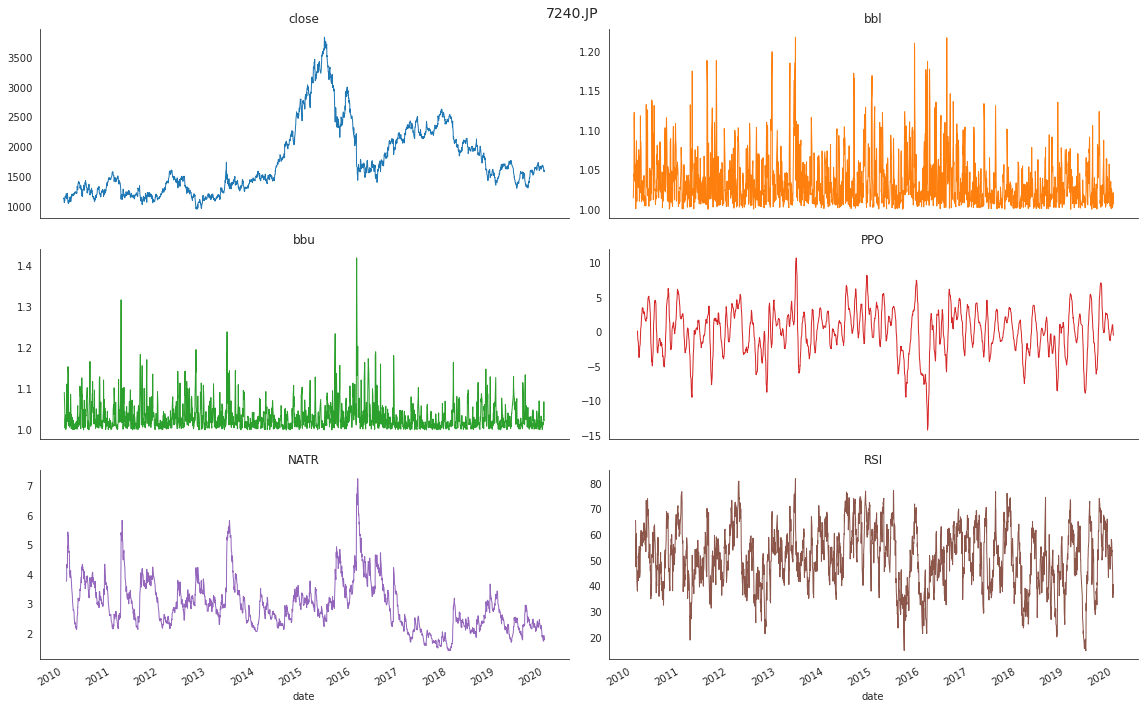

time: 1.62 s (started: 2021-04-28 01:25:37 +00:00)


In [20]:
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

### Create time period indicators

In [22]:
# drop prices
data = data.drop(prices.columns, axis=1)

dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

time: 762 ms (started: 2021-04-28 01:27:02 +00:00)


## Compute forward returns

In [23]:
outcomes = []
by_ticker = data.groupby('ticker')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_ticker[f'ret_{t}'].shift(-t)
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            2303568 non-null  float64
 1   ret_rel_perc_1   2303568 non-null  float64
 2   ret_5            2299804 non-null  float64
 3   ret_rel_perc_5   2299804 non-null  float64
 4   ret_10           2295099 non-null  float64
 5   ret_rel_perc_10  2295099 non-null  float64
 6   ret_21           2284748 non-null  float64
 7   ret_rel_perc_21  2284748 non-null  float64
 8   ret_63           2245226 non-null  float64
 9   ret_rel_perc_63  2245226 non-null  float64
 10  PPO              2280984 non-null  float64
 11  NATR             2291335 non-null  float64
 12  RSI              2291335 non-null  float64
 13  bbl              2300745 non-null  float64
 14  bbu              2300745 non-nul

In [24]:
data.to_csv(path_data / 'stooq_jp_equities.csv')
!zip -u stooq_jp_data.zip data/stooq_jp_equities.csv
!gsutil cp stooq_jp_data.zip gs://finance_data_bucket/lbk/rf/

  adding: data/stooq_jp_equities.csv (deflated 65%)
Copying file://stooq_jp_data.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][401.4 MiB/401.4 MiB]                                                
Operation completed over 1 objects/401.4 MiB.                                    
time: 2min 15s (started: 2021-04